# Late Fusion with Feature Concatenation

This notebook implements late fusion by concatenating features from:
- Audio: Wav2Vec2 model
- Vision: ResNet50 model

The approach:
1. Load pre-trained audio and vision models
2. Extract features from both models (remove classification heads)
3. Concatenate features
4. Train a fusion classifier on concatenated features


In [1]:
# =============================================================================
# STEP 0: SETUP, LIBRARIES & DATA PREPARATION
# =============================================================================
import sys

# Use pip from current kernel's Python executable
print(f"Using pip from {sys.executable}...")

# Install required libraries
!{sys.executable} -m pip install matplotlib seaborn tqdm librosa pandas scikit-learn torchvision opencv-python -q
!{sys.executable} -m pip install transformers[torch] accelerate -q

print("--- All libraries installed! ---")

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import subprocess
import cv2
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using pip from /home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/bin/python...

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
--- All libraries installed! ---


/home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda


## Data Loading and Preparation

Load audio and vision data, ensuring consistent video_id matching for fusion.


In [ ]:
# =============================================================================
# STEP 1: LOAD DATA (Audio + Vision)
# =============================================================================

# Paths
RAVDESS_AUDIO_PATH = "/home/siyi/ravdess_audio"
RAVDESS_VIDEO_PATH = "/home/siyi/ravdess_dataset"
FRAMES_DIR = "/home/siyi/ravdess_frames"

# Emotion to sentiment mapping (same as both notebooks)
emotion_to_sentiment = {
    'neutral': 0,   # neutral
    'calm': 0,      # neutral
    'happy': 1,     # positive
    'surprised': 1, # positive
    'sad': 2,       # negative
    'angry': 2,     # negative
    'fearful': 2,   # negative
    'disgust': 2    # negative
}

ravdess_emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

sentiment_list = ['neutral', 'positive', 'negative']

# --- Load Audio Data ---
print("Loading audio data...")
audio_data = []
for filename in os.listdir(RAVDESS_AUDIO_PATH):
    if filename.endswith('.wav'):
        video_id = os.path.splitext(filename)[0]
        parts = video_id.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = ravdess_emotion_map.get(emotion_code)
            if emotion:
                audio_data.append({
                    'video_id': video_id,
                    'audio_path': os.path.join(RAVDESS_AUDIO_PATH, filename),
                    'emotion': emotion,
                    'label': emotion_to_sentiment[emotion]
                })

audio_df = pd.DataFrame(audio_data)
audio_df = audio_df.sort_values('video_id').reset_index(drop=True)
print(f"✅ Loaded {len(audio_df)} audio files")

# --- Load Vision Data (frames) ---
print("Loading vision data...")
vision_data = []
for filename in os.listdir(FRAMES_DIR):
    if filename.endswith('.jpg'):
        # Extract video_id from frame filename (e.g., "01-01-01-01-01-01-01_frame_000.jpg")
        video_id = filename.split('_frame_')[0]
        parts = video_id.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = ravdess_emotion_map.get(emotion_code)
            if emotion:
                vision_data.append({
                    'video_id': video_id,
                    'frame_path': os.path.join(FRAMES_DIR, filename),
                    'emotion': emotion,
                    'label': emotion_to_sentiment[emotion]
                })

vision_df = pd.DataFrame(vision_data)
print(f"✅ Loaded {len(vision_df)} vision frames")

# --- Group vision frames by video_id (collect all frames per video, same as single-modal) ---
# Single-modal extracted 5 frames, collect all frames per video_id here
vision_df_grouped = vision_df.groupby('video_id').agg({
    'frame_path': list,  # Collect all frame paths
    'emotion': 'first',  # Emotion label (same for all frames)
    'label': 'first'     # Label (same for all frames)
}).reset_index()

# Check number of frames per video (should be 5 frames)
frames_per_video = vision_df_grouped['frame_path'].apply(len)
print(f"✅ Frames per video: min={frames_per_video.min()}, max={frames_per_video.max()}, mean={frames_per_video.mean():.1f}")
print(f"✅ Grouped to {len(vision_df_grouped)} unique videos")
print(frames_per_video.value_counts())

# --- Merge audio and vision data by video_id ---
fusion_df = audio_df.merge(
    vision_df_grouped[['video_id', 'frame_path', 'emotion', 'label']],
    on='video_id',
    suffixes=('_audio', '_vision'),
    how='inner'
)

# Verify labels match
assert (fusion_df['label_audio'] == fusion_df['label_vision']).all(), "Label mismatch!"
fusion_df['label'] = fusion_df['label_audio']
fusion_df = fusion_df.drop(['label_audio', 'label_vision'], axis=1)

print(f"✅ Merged dataset: {len(fusion_df)} samples with both audio and vision")
print(f"   Each sample has audio + {frames_per_video.iloc[0]} vision frames")

# --- Split by actor ID (using audio notebook's split: train 1-16, val 17-21, test 22-24) ---
fusion_df['actor_id'] = fusion_df['video_id'].apply(lambda x: int(x.split('-')[-1]))

train_actor_ids = list(range(1, 19))
val_actor_ids = list(range(19, 22))
test_actor_ids = list(range(22, 25))

train_df = fusion_df[fusion_df['actor_id'].isin(train_actor_ids)].copy().reset_index(drop=True)
val_df = fusion_df[fusion_df['actor_id'].isin(val_actor_ids)].copy().reset_index(drop=True)
test_df = fusion_df[fusion_df['actor_id'].isin(test_actor_ids)].copy().reset_index(drop=True)

# Verify data split is correct, check for overlaps
train_video_ids = set(train_df['video_id'].unique())
val_video_ids = set(val_df['video_id'].unique())
test_video_ids = set(test_df['video_id'].unique())

print(f"\n🔍 Data split verification:")
print(f"  Train videos: {len(train_video_ids)}")
print(f"  Val videos: {len(val_video_ids)}")
print(f"  Test videos: {len(test_video_ids)}")
print(f"  Train-Val overlap: {len(train_video_ids & val_video_ids)}")
print(f"  Train-Test overlap: {len(train_video_ids & test_video_ids)}")
print(f"  Val-Test overlap: {len(val_video_ids & test_video_ids)}")

if len(train_video_ids & val_video_ids) > 0 or len(train_video_ids & test_video_ids) > 0 or len(val_video_ids & test_video_ids) > 0:
    print("  ⚠️  WARNING: Data leakage detected! There are overlapping videos between splits!")
else:
    print("  ✅ No data leakage detected.")

print(f"\n📊 Data split:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"\nTrain label distribution:")
print(train_df['label'].value_counts().sort_index())
print(f"\nVal label distribution:")
print(val_df['label'].value_counts().sort_index())
print(f"\nTest label distribution:")
print(test_df['label'].value_counts().sort_index())


Loading audio data...
✅ Loaded 2452 audio files
Loading vision data...
✅ Loaded 11428 vision frames
✅ Frames per video: min=4, max=5, mean=4.7
✅ Grouped to 2452 unique videos
frame_path
5    1620
4     832
Name: count, dtype: int64
✅ Merged dataset: 2452 samples with both audio and vision
   Each sample has audio + 4 vision frames

🔍 Data split verification:
  Train videos: 1828
  Val videos: 312
  Test videos: 312
  Train-Val overlap: 0
  Train-Test overlap: 0
  Val-Test overlap: 0
  ✅ No data leakage detected.

📊 Data split:
Train: 1828 | Val: 312 | Test: 312

Train label distribution:
label
0    420
1    424
2    984
Name: count, dtype: int64

Val label distribution:
label
0     72
1     72
2    168
Name: count, dtype: int64

Test label distribution:
label
0     72
1     72
2    168
Name: count, dtype: int64


## Load Pre-trained Models and Extract Features

Load the pre-trained audio and vision models, modify them to extract features instead of classifications.


In [3]:
# =============================================================================
# STEP 2: LOAD PRE-TRAINED MODELS (Feature Extractors)
# =============================================================================

# --- Load Audio Model (Wav2Vec2) ---
print("Loading audio model (Wav2Vec2)...")
AUDIO_MODEL_PATH = "/home/siyi/multimodal_final/multimodal-sentiment-analysis/notebooks/best_wav2vec2_two_stage.pth"
MODEL_CHECKPOINT = "facebook/wav2vec2-base"
TARGET_SAMPLING_RATE = 16000

from transformers import AutoFeatureExtractor
audio_feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

# Load model
audio_model = AutoModelForAudioClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=3
).to(device)

# Load weights
if os.path.exists(AUDIO_MODEL_PATH):
    audio_model.load_state_dict(torch.load(AUDIO_MODEL_PATH, map_location=device))
    print("✅ Loaded audio model weights")
else:
    print("⚠️  Audio model weights not found, using pre-trained only")

# Freeze audio model and use as feature extractor
for param in audio_model.parameters():
    param.requires_grad = False
audio_model.eval()

# Get audio feature dimension (from projector output)
# Wav2Vec2ForSequenceClassification has: wav2vec2 -> projector -> classifier
# We'll extract features after projector
audio_feature_dim = audio_model.projector.out_features
print(f"Audio feature dimension: {audio_feature_dim}")

# --- Load Vision Model (ResNet50) ---
print("\nLoading vision model (ResNet50)...")
VISION_MODEL_PATH = "/home/siyi/multimodal_final/multimodal-sentiment-analysis/model_weights/resnet50_fer2013_sentiment.pth"

# Load ResNet50
vision_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, 3)  # 3 classes

# Move model to device BEFORE loading weights
vision_model = vision_model.to(device)

# Load weights
if os.path.exists(VISION_MODEL_PATH):
    vision_model.load_state_dict(torch.load(VISION_MODEL_PATH, map_location=device))
    print("✅ Loaded vision model weights")
else:
    print("⚠️  Vision model weights not found, using ImageNet pre-trained only")

# Freeze vision model and use as feature extractor
for param in vision_model.parameters():
    param.requires_grad = False
vision_model.eval()

# Create a feature extractor function for ResNet50
def extract_resnet_features(model, image):
    """Extract features from ResNet50 before the fc layer"""
    x = model.conv1(image)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    x = model.avgpool(x)
    x = torch.flatten(x, 1)
    return x

# Get vision feature dimension (before fc layer)
vision_feature_dim = num_ftrs  # 2048 for ResNet50
print(f"Vision feature dimension: {vision_feature_dim}")

# Total fused feature dimension
fused_feature_dim = audio_feature_dim + vision_feature_dim
print(f"\n✅ Total fused feature dimension: {fused_feature_dim} ({audio_feature_dim} + {vision_feature_dim})")


Loading audio model (Wav2Vec2)...


/home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded audio model weights
Audio feature dimension: 256

Loading vision model (ResNet50)...
✅ Loaded vision model weights
Vision feature dimension: 2048

✅ Total fused feature dimension: 2304 (256 + 2048)


In [ ]:
# =============================================================================
# STEP 3: DATASET FOR FEATURE EXTRACTION
# =============================================================================

class FusionDataset(Dataset):
    """Dataset that extracts features from both audio and vision models"""
    
    def __init__(self, df, audio_model, vision_model, audio_feature_extractor, 
                 vision_transform, extract_resnet_fn, max_duration_s=5.0):
        self.df = df
        self.audio_model = audio_model
        self.vision_model = vision_model
        self.audio_feature_extractor = audio_feature_extractor
        self.vision_transform = vision_transform
        self.extract_resnet_fn = extract_resnet_fn
        self.max_length = int(max_duration_s * TARGET_SAMPLING_RATE)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['audio_path']
        frame_paths = row['frame_path']  # Now a list containing multiple frame paths
        label = row['label']
        
        # Ensure frame_paths is a list
        if isinstance(frame_paths, str):
            frame_paths = [frame_paths]
        
        # Extract audio features
        try:
            audio, sr = librosa.load(audio_path, sr=None)
            if sr != TARGET_SAMPLING_RATE:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SAMPLING_RATE)
            
            audio_tensor = torch.tensor(audio).float()
            if len(audio_tensor) > self.max_length:
                audio_tensor = audio_tensor[:self.max_length]
            else:
                pad_len = self.max_length - len(audio_tensor)
                audio_tensor = torch.nn.functional.pad(audio_tensor, (0, pad_len))
            
            inputs = self.audio_feature_extractor(
                audio_tensor.numpy(),
                sampling_rate=TARGET_SAMPLING_RATE,
                max_length=self.max_length,
                truncation=True,
                padding="max_length",
                return_attention_mask=True,
                return_tensors="pt"
            )
            
            # input_values = inputs.input_values.squeeze(0).to(device)
            # attention_mask = inputs.attention_mask.squeeze(0).to(device)

            input_values = inputs.input_values.to(device)
            attention_mask = inputs.attention_mask.to(device)
            
            with torch.no_grad():
                audio_outputs = self.audio_model.wav2vec2(input_values, attention_mask=attention_mask)
                # Get pooled output (mean pooling over sequence)
                audio_features = audio_outputs.last_hidden_state.mean(dim=1)  # [batch, hidden_dim]
                # Project to feature space
                audio_features = self.audio_model.projector(audio_features)  # [batch, audio_feature_dim]
                audio_features = audio_features.squeeze(0).cpu()
        except Exception as e:
            print(f"Error processing audio {audio_path}: {e}")
            audio_features = torch.zeros(audio_feature_dim)
        
        # Extract vision features from multiple frames (same as single-modal: 5 frames)
        # Extract features from all frames, then average pool
        vision_features_list = []
        for frame_path in frame_paths:
            try:
                image = Image.open(frame_path).convert('RGB')
                image = self.vision_transform(image).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    # Extract features using helper function
                    frame_features = self.extract_resnet_fn(self.vision_model, image)
                    vision_features_list.append(frame_features.squeeze(0).cpu())
            except Exception as e:
                print(f"Error processing vision frame {frame_path}: {e}")
                vision_features_list.append(torch.zeros(vision_feature_dim))
        
        # Average pool features from all frames (consistent with single-modal approach: multi-frame feature aggregation)
        if len(vision_features_list) > 0:
            vision_features = torch.stack(vision_features_list).mean(dim=0)  # [feature_dim]
        else:
            vision_features = torch.zeros(vision_feature_dim)
        
        # Concatenate features
        fused_features = torch.cat([audio_features, vision_features], dim=0)
        
        return fused_features, label

# Vision transform (same as vision notebook)
# Note: No data augmentation here since feature extractor is frozen, augmentation won't affect feature extraction
vision_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
print("Creating datasets...")
train_fusion_dataset = FusionDataset(train_df, audio_model, vision_model, 
                                     audio_feature_extractor, vision_transform, extract_resnet_features)
val_fusion_dataset = FusionDataset(val_df, audio_model, vision_model, 
                                   audio_feature_extractor, vision_transform, extract_resnet_features)
test_fusion_dataset = FusionDataset(test_df, audio_model, vision_model, 
                                    audio_feature_extractor, vision_transform, extract_resnet_features)

print("✅ Datasets created (before PCA)")


Creating datasets...
✅ Datasets created (before PCA)


## PCA Dimensionality Reduction

Extract all features first, then apply PCA to reduce dimensionality and prevent overfitting.


In [ ]:
# =============================================================================
# STEP 3.5: EXTRACT FEATURES AND APPLY PCA
# =============================================================================

print("Extracting features from all datasets...")

def extract_all_features(dataset):
    """Extract all features from a dataset"""
    all_features = []
    all_labels = []
    
    for idx in tqdm(range(len(dataset)), desc="Extracting features"):
        features, label = dataset[idx]
        all_features.append(features.numpy())
        all_labels.append(label)
    
    return np.array(all_features), np.array(all_labels)

# Extract features from all datasets
print("\nExtracting training features...")
train_features, train_labels = extract_all_features(train_fusion_dataset)
print(f"  Train features shape: {train_features.shape}")

print("\nExtracting validation features...")
val_features, val_labels = extract_all_features(val_fusion_dataset)
print(f"  Val features shape: {val_features.shape}")

print("\nExtracting test features...")
test_features, test_labels = extract_all_features(test_fusion_dataset)
print(f"  Test features shape: {test_features.shape}")

# Apply PCA - fit on training set only
print("\n" + "="*60)
print("Applying PCA dimensionality reduction...")
print("="*60)

# Choose target dimension: retain 95% variance, or fixed dimension (take smaller value)
# For 1920 samples, can only reduce to 1920-1=1919 dimensions (sample count - 1)
# We choose to retain 512 dimensions to balance dimensionality reduction and information retention
target_dim = min(512, len(train_features) - 1, train_features.shape[1])

pca = PCA(n_components=target_dim)
pca.fit(train_features)

# Calculate retained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_.sum()
print(f"\n✅ PCA fitted on training set")
print(f"   Original dimension: {train_features.shape[1]}")
print(f"   Reduced dimension: {target_dim}")
print(f"   Explained variance ratio: {explained_variance_ratio:.4f} ({explained_variance_ratio*100:.2f}%)")

# Transform all datasets
print("\nTransforming features...")
train_features_pca = pca.transform(train_features)
val_features_pca = pca.transform(val_features)
test_features_pca = pca.transform(test_features)

print(f"  Train features after PCA: {train_features_pca.shape}")
print(f"  Val features after PCA: {val_features_pca.shape}")
print(f"  Test features after PCA: {test_features_pca.shape}")

# Update fused feature dimension
fused_feature_dim = target_dim
print(f"\n✅ Updated fused feature dimension: {fused_feature_dim}")


Extracting features from all datasets...

Extracting training features...


Extracting features: 100%|██████████| 1828/1828 [02:35<00:00, 11.73it/s]


  Train features shape: (1828, 2304)

Extracting validation features...


Extracting features: 100%|██████████| 312/312 [00:26<00:00, 11.84it/s]


  Val features shape: (312, 2304)

Extracting test features...


Extracting features: 100%|██████████| 312/312 [00:28<00:00, 11.07it/s]


  Test features shape: (312, 2304)

Applying PCA dimensionality reduction...

✅ PCA fitted on training set
   Original dimension: 2304
   Reduced dimension: 512
   Explained variance ratio: 0.9877 (98.77%)

Transforming features...
  Train features after PCA: (1828, 512)
  Val features after PCA: (312, 512)
  Test features after PCA: (312, 512)

✅ Updated fused feature dimension: 512


## Create Dataset with PCA-reduced Features

Create a new dataset class that uses pre-extracted PCA-reduced features.


In [6]:
# =============================================================================
# STEP 3.6: CREATE DATASET WITH PCA-REDUCED FEATURES
# =============================================================================

class PCADataset(Dataset):
    """Dataset using pre-extracted PCA-reduced features"""
    
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets with PCA-reduced features
train_pca_dataset = PCADataset(train_features_pca, train_labels)
val_pca_dataset = PCADataset(val_features_pca, val_labels)
test_pca_dataset = PCADataset(test_features_pca, test_labels)

# Create dataloaders
train_loader = DataLoader(train_pca_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_pca_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_pca_dataset, batch_size=32, shuffle=False, num_workers=0)

print("✅ Datasets and DataLoaders created with PCA-reduced features")


✅ Datasets and DataLoaders created with PCA-reduced features


## Fusion Classifier Model

Define a simple classifier that takes PCA-reduced features and outputs sentiment predictions.


In [ ]:
# =============================================================================
# STEP 4: FUSION CLASSIFIER MODEL
# =============================================================================

class FusionClassifier(nn.Module):
    """Classifier for concatenated audio + vision features"""
    
    def __init__(self, input_dim, num_classes=3, hidden_dim=256, dropout=0.5):
        super(FusionClassifier, self).__init__()
        # Reduce model complexity, increase dropout to prevent overfitting
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

# Create fusion model (using PCA-reduced feature dimension)
fusion_model = FusionClassifier(
    input_dim=fused_feature_dim,  # Now PCA-reduced dimension (512)
    num_classes=3,
    hidden_dim=256,  # Keep 256 since input is already reduced
    dropout=0.5
).to(device)

print(f"✅ Fusion model created")
print(f"   Input dim: {fused_feature_dim}")
print(f"   Output dim: 3 (sentiment classes)")
print(f"   Total parameters: {sum(p.numel() for p in fusion_model.parameters()):,}")

# Loss and optimizer
class_weights_np = compute_class_weight(
    'balanced',
    classes=np.arange(3),
    y=train_df['label']
)
class_weights_np[0] *= 1.2  # Neutral
class_weights_np[1] *= 1.1  # Positive
class_weights_np[2] *= 0.9  # Negative class (reduce weight slightly)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
# Reduce learning rate, increase weight decay to prevent overfitting
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

print("\nClass weights:")
for sentiment, w in zip(sentiment_list, class_weights.cpu().numpy()):
    print(f"  {sentiment:10s} : {w:.4f}")


✅ Fusion model created
   Input dim: 512
   Output dim: 3 (sentiment classes)
   Total parameters: 165,379

类别权重:
  neutral    : 1.7410
  positive   : 1.5808
  negative   : 0.5573


## Training Loop

Train the fusion classifier on concatenated features.


In [ ]:
# =============================================================================
# STEP 5: TRAINING LOOP
# =============================================================================
import time

num_epochs = 15
best_val_acc = 0.0
patience = 5
counter = 0

train_accs = []
val_accs = []

# Record start time
start_time = time.time()

for epoch in range(num_epochs):
    # Training
    fusion_model.train()  # Ensure dropout and batchnorm are in training mode
    train_correct = 0
    train_total = 0
    
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = fusion_model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(fusion_model.parameters(), 1.0)
        optimizer.step()
        
        # Use eval mode when calculating accuracy during training to avoid dropout effects
        fusion_model.eval()
        with torch.no_grad():
            preds = fusion_model(features).argmax(dim=1)
        fusion_model.train()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation
    fusion_model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = fusion_model(features)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    scheduler.step()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(fusion_model.state_dict(), "best_fusion_classifier.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break

# Record end time
end_time = time.time()
total_time = end_time - start_time

# Display final results
print("\n" + "="*60)
print("Training Completed!")
print("="*60)
print(f"Final Train Accuracy: {train_accs[-1]:.4f} ({train_accs[-1]*100:.2f}%)")
print(f"Final Val Accuracy: {val_accs[-1]:.4f} ({val_accs[-1]*100:.2f}%)")
print(f"Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Total Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print("="*60)


Epoch 14/15: 100%|██████████| 58/58 [00:00<00:00, 217.89it/s]


Training Completed!
Final Train Accuracy: 1.0000 (100.00%)
Final Val Accuracy: 0.8750 (87.50%)
Best Val Accuracy: 0.8814 (88.14%)
Total Training Time: 3.75 seconds (0.06 minutes)


## Evaluation

Evaluate the fusion model on the test set.


--- Evaluating Fusion Model on Test Set ---


Evaluating: 100%|██████████| 10/10 [00:00<00:00, 730.03it/s]


--- Fusion Model Classification Report (3 Sentiment Classes) ---
              precision    recall  f1-score   support

     neutral       0.84      0.74      0.79        72
    positive       0.88      0.78      0.82        72
    negative       0.89      0.98      0.93       168

    accuracy                           0.88       312
   macro avg       0.87      0.83      0.85       312
weighted avg       0.87      0.88      0.87       312


--- Detailed Metrics ---
Accuracy: 0.8750

Per-class metrics:
  neutral   : Precision=0.8413, Recall=0.7361, F1=0.7852, Support=72
  positive  : Precision=0.8750, Recall=0.7778, F1=0.8235, Support=72
  negative  : Precision=0.8865, Recall=0.9762, F1=0.9292, Support=168

Macro average: Precision=0.8676, Recall=0.8300, F1=0.8460
Weighted average: Precision=0.8734, Recall=0.8750, F1=0.8716


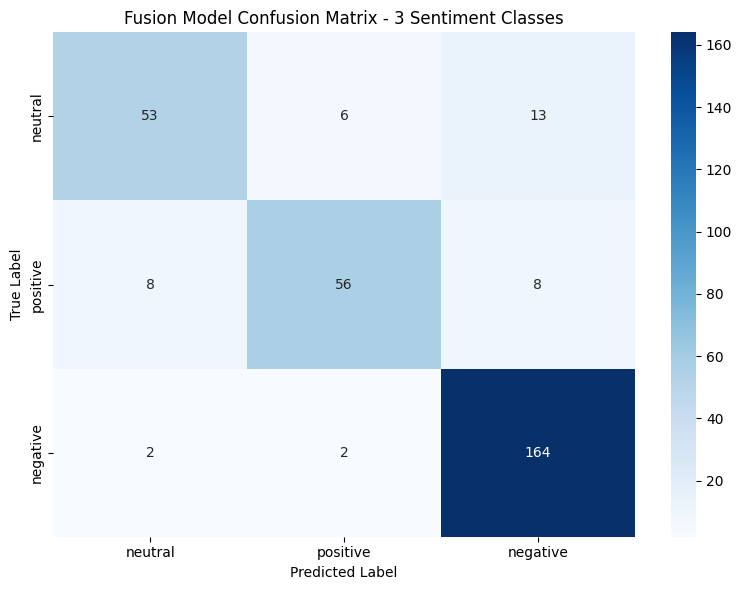

In [9]:
# =============================================================================
# STEP 6: EVALUATION
# =============================================================================

print("--- Evaluating Fusion Model on Test Set ---")

# Load best model
fusion_model.load_state_dict(torch.load("best_fusion_classifier.pth"))
fusion_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in tqdm(test_loader, desc="Evaluating"):
        features = features.to(device)
        outputs = fusion_model(features)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro', zero_division=0
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

# Classification Report
print("\n--- Fusion Model Classification Report (3 Sentiment Classes) ---")
print(classification_report(all_labels, all_preds, target_names=sentiment_list))

# Print detailed metrics
print("\n--- Detailed Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nPer-class metrics:")
for i, sentiment in enumerate(sentiment_list):
    print(f"  {sentiment:10s}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}, Support={support[i]}")
print(f"\nMacro average: Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, F1={f1_macro:.4f}")
print(f"Weighted average: Precision={precision_weighted:.4f}, Recall={recall_weighted:.4f}, F1={f1_weighted:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sentiment_list,
    yticklabels=sentiment_list
)
plt.title('Fusion Model Confusion Matrix - 3 Sentiment Classes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## Training Curves

Visualize training and validation metrics over epochs.


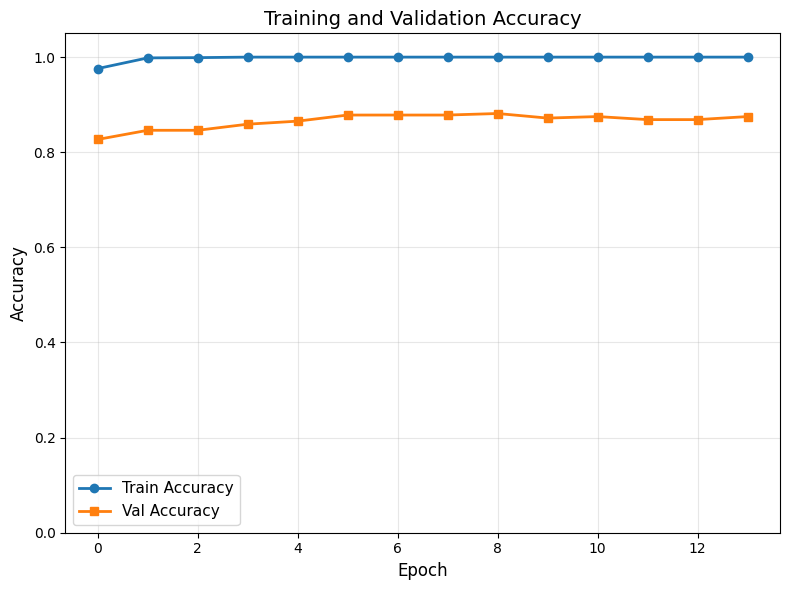


Best validation accuracy: 0.8814 (88.14%)


In [10]:
# =============================================================================
# STEP 7: PLOT TRAINING CURVES
# =============================================================================

epochs_range = range(len(train_accs))

plt.figure(figsize=(8, 6))

plt.plot(epochs_range, train_accs, label='Train Accuracy', marker='o', linewidth=2)
plt.plot(epochs_range, val_accs, label='Val Accuracy', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])

plt.tight_layout()
plt.show()

print(f"\nBest validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
